Опробуем на Сиэтловском датасете дистилляцию

* id - идентификационный номер жилья
* date - дата продажи дома
* price - цена
* bedrooms - количество спален
* bathrooms - количество ванных комнат, где .5 означает комнату с туалетом, но без душа
* sqft_living - площадь жилья
* sqft_lot - площадь участка
* floors - количество этажей
* waterfront - видна ли набережная
* view - насколько хороший вид
* condition - индекс от 1 от 5, отвечающий за состояние квартиры
* grade - 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна, 3-7 - средний уровень, 11-13 -высокий.
* sqft_above - жилая площадь над уровнем земли
* sqft_basement - жилая площадь под уровнем земли
* yr_built - год постройки жилья
* yr_renovated - год последней реконструкции жилья
* zipcode - почтовый индекс
* lat - широта
* long - долгота
* sqft_living15 - средняя площадь жилья ближайших 15-и соседей
* sqft_lot15 - средняя площадь участка ближайших 15-и соседей

In [0]:
import json
import csv
import pandas as pd
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
import seaborn as sns
import warnings
import requests
from sklearn import cluster, datasets
import os
from joblib import dump, load
import lightgbm
import lightgbm as lgb
from tqdm import tqdm_notebook

from copy import deepcopy
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import lightgbm as lgb


warnings.simplefilter("ignore")

### Здесь - стандартный процессинг данных, включая работу knn - а. Ничего особенного.

In [0]:
! wget "https://mipt-stats.gitlab.io/files/ml/hw2/houses_train.csv"
! wget "https://mipt-stats.gitlab.io/files/ml/hw2/houses_test.csv"
! mkdir houses-for-cats
! mv houses_train.csv houses-for-cats/houses_train.csv
! mv houses_test.csv houses-for-cats/houses_test.csv
! ls 'houses-for-cats'

--2019-04-24 21:21:58--  https://mipt-stats.gitlab.io/files/ml/hw2/houses_train.csv
Resolving mipt-stats.gitlab.io (mipt-stats.gitlab.io)... 35.185.44.232
Connecting to mipt-stats.gitlab.io (mipt-stats.gitlab.io)|35.185.44.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1730890 (1.7M) [text/csv]
Saving to: ‘houses_train.csv’

houses_train.csv    100%[===================>]   1.65M  --.-KB/s    in 0.02s   

2019-04-24 21:21:59 (74.1 MB/s) - ‘houses_train.csv’ saved [1730890/1730890]

--2019-04-24 21:22:00--  https://mipt-stats.gitlab.io/files/ml/hw2/houses_test.csv
Resolving mipt-stats.gitlab.io (mipt-stats.gitlab.io)... 35.185.44.232
Connecting to mipt-stats.gitlab.io (mipt-stats.gitlab.io)|35.185.44.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 713050 (696K) [text/csv]
Saving to: ‘houses_test.csv’

houses_test.csv     100%[===================>] 696.34K  --.-KB/s    in 0.01s   

2019-04-24 21:22:00 (61.6 MB/s) - ‘houses_test.

In [0]:
def mape(y_actual, y_estim):
    return np.mean(np.abs((y_actual - y_estim) / y_actual))
  
def get_date(df, i, t='year'):
    s = df['date'][i].split('T')[0]
    year=int(s[:4])
    month=int(s[4:6])
    day=int(s[6:8])
    if t == 'year':
        return (year - 2015) * 12 + month

def preprocess_df(df):
    if 'id' in df.columns:
      df = df.drop('id', axis=1)
    # Точно ли это делать?
    if 'zipcode' in df.columns:
      df = df.drop('zipcode', axis=1)
    if 'price' in df.columns:
      df['target'] = df['price'] / df['sqft_living']
      df = df.drop('price', axis=1)
    years = [get_date(df, i) for i in range(len(df))]
    df['date'] = years
    # df = df[df['sqft_lot'] - df['sqft_living'] < 300000]
    return df

In [0]:
df = pd.read_csv('houses-for-cats/houses_train.csv')
df = shuffle(df)
df = preprocess_df(df)
df.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,target
10220,10,5,3.50,3260,58806,2.0,0,0,4,8,3260,0,1969,0,47.3703,-122.159,1810,17927,174.371166
10665,12,2,2.75,1430,1425,2.0,0,0,3,7,995,435,2006,0,47.6210,-122.298,1500,1749,325.174825
11069,12,5,2.75,2210,13500,1.0,0,0,5,7,1460,750,1963,0,47.4468,-122.282,1590,10850,142.081448
7078,14,4,2.25,2130,11843,2.0,0,0,4,9,2130,0,1972,0,47.5358,-122.225,2380,11643,399.061033
12289,6,3,2.50,2690,21883,2.0,0,0,3,8,2690,0,1994,0,47.6462,-121.904,2370,21781,165.427509


In [0]:
df.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'target'],
      dtype='object')

Ну, понеслась

In [0]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

Пользуемся knn-ом. Используем оптимальный регрессор. Конечено, учет цены на квадратный метр в нашем случае, когда есть участки, не совсем корректен, но некоторый смысл все равно будет

In [0]:
def get_best_knn_estimator():
    cv = KFold(n_splits=7, shuffle=True, random_state=101)
    knn_params = {'n_neighbors': range(30, 35),
                  'weights': ['uniform', 'distance']}
    knn_X = X_train[['lat', 'long']].values
    knn_y = y_train.values

    knn_regressor = KNeighborsRegressor()
    knn_grid = GridSearchCV(knn_regressor, knn_params, cv=cv, verbose=True)
    knn_grid.fit(knn_X, knn_y)
    knn_estimator = knn_grid.best_estimator_
    return knn_estimator, knn_grid.best_params_

knn_best, _ = get_best_knn_estimator()
knn_best.fit(X_train[['lat', 'long']].values, y_train.values)
X_val['knn estim'] = knn_best.predict(X_val[['lat', 'long']].values)
mape(y_val, X_val['knn estim'])

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    5.8s finished


0.18832450880700652

In [0]:
def make_knn_prediction_for_train(Xtrain = X_train, ytrain = y_train):
    knn_estimator = deepcopy(knn_best)
    knn_prediction = np.zeros(len(Xtrain))
    skf = KFold(n_splits=10)

    knn_X = Xtrain[['lat', 'long']].values
    knn_y = ytrain.values

    for train_index, test_index in tqdm(skf.split(knn_X)):
        knn_X_train, knn_X_test = knn_X[train_index], knn_X[test_index]
        knn_y_train = knn_y[train_index]

        knn_estimator.fit(knn_X_train, knn_y_train)
        knn_prediction[test_index] = knn_estimator.predict(knn_X_test)
    return knn_prediction

In [0]:
X_train['knn estim'] = make_knn_prediction_for_train()
#X_val['knn estim'] = deepcopy(knn_best).fit(X_train[['lat', 'long']], y_train).predict(X_val[['lat', 'long']])
mape(y_train, X_train['knn estim'])

10it [00:00, 76.16it/s]


0.1888593958564522

In [0]:
mape(y_val, X_val['knn estim'])

0.18832450880700652

### Начнем с того, что посмотрим, какое качество мы можем достичь на выборке, когда нам дан полный датасет.

In [0]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mape'},
    'num_leaves': 60,
    'learning_rate': 0.1,
    'verbose': 0
}

In [0]:
X_train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'knn estim'],
      dtype='object')

Теперь применяем бустинг с подбором параметров. Ничего особенного, кроме того, что занятие само по себе довольно медленное, поэтому делал на самом деле несколько запусков с целью поиска, в какой стороне искать оптимум. В итоговом коде вообще оставил оптимальные параметры, ибо иначе долго считается

In [0]:
params = {
    'objective': 'regression',
    'metric': {'mape'},
    'num_leaves': 60,
    'verbose': 0
}

  
def get_best_model(X_train, y_train, X_val, y_val):
  model = lgb.LGBMRegressor(params)
  model = GridSearchCV(model, param_grid, cv=3)
  model.fit(X_train.values, y_train)
  return model.best_estimator_, model.best_params_

In [0]:
param_grid = {
    'learning_rate': [ 0.1],
    'n_estimators': [20],
    'num_boost_round': [125], #[3000], #[25, 50, 75, 100, 125, 150, 175],
    'boosting_type': ['gbdt'],
}

subset = X_train.columns

model_all_features, model_best_params = get_best_model(X_train[subset], 
                                     y_train, X_val[subset], y_val)
pred_val = model_all_features.predict(X_val[subset].values)
pred_train = model_all_features.predict(X_train[subset].values)
print("MAPE on train: ", mape(y_train, pred_train))
print("MAPE on val: ",mape(y_val, pred_val))

imp_df = pd.DataFrame()
imp_df["feature"] = subset
model = model_all_features
imp_df["importance_gain"] = model.feature_importances_#(importance_type='gain')
#imp_df["importance_split"] = model.feature_importance(importance_type='split')
imp_df.sort_values('importance_gain', ascending=False)

MAPE on train:  0.10257934085538695
MAPE on val:  0.12502064752196543


,feature,importance_gain
3,sqft_living,490
18,knn estim,364
12,yr_built,348
4,sqft_lot,315
15,long,312
16,sqft_living15,276
14,lat,266
9,grade,230
10,sqft_above,201
17,sqft_lot15,198


In [0]:
model_best_params

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'n_estimators': 20,
 'num_boost_round': 125}

### Сохраняем наилучший (а возможно, слегка переобученный) вариант ответа учителя для дальнейших нужд:

In [0]:
teacher_prediction = pred_train

### Что же, теперь смотрим, что мы можем изменить, обучая датасет на правильных ответах и на ответах учителя

In [0]:
X_train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'knn estim'],
      dtype='object')

In [0]:
nboost = 125
param_grid = {
    'learning_rate': [ 0.1],
    'n_estimators': [20],
    'num_boost_round': [nboost],
    'boosting_type': ['gbdt'],
}

subset = ['sqft_living', 'lat', 'long', 'knn estim']

### Обучаем градиентные бустинги на только минимальном числе фич, и при этом имея лишь верные ответы

In [0]:
subset

['sqft_living', 'lat', 'long', 'knn estim']

In [0]:
nboosts = np.linspace(50, 300, 250 // 25).astype(int)
pred_trains = []
pred_vals = []

for nboost in tqdm(nboosts):
  param_grid['num_boost_round'] = [nboost]
  model, params = get_best_model(X_train[subset], y_train, X_val[subset], y_val)

  pred_train = model.predict(X_train[subset].values)
  pred_val = model.predict(X_val[subset].values)  
  
  pred_trains.append(mape(y_train, pred_train))
  pred_vals.append(mape(y_val, pred_val))

100%|██████████| 10/10 [00:12<00:00,  1.68s/it]


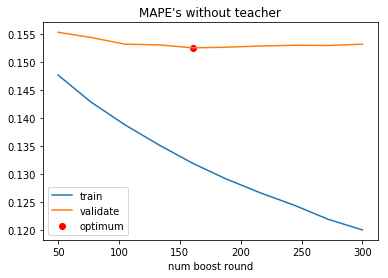

In [0]:
plt.title('MAPE\'s without teacher')
plt.plot(nboosts, pred_trains, label='train')
plt.plot(nboosts, pred_vals, label='validate')
i_optim = np.argmin(pred_vals)
plt.scatter(nboosts[i_optim], pred_vals[i_optim], label='optimum', c='r')
plt.xlabel('num boost round')
plt.legend()
best_score = pred_vals[i_optim]

In [0]:
print("The best number of boost rounds is {}".format(nboosts[i_optim]))

print("Best score for multimodelling is {}".format(best_score))

The best number of boost rounds is 161
Best score for multimodelling is 0.1525371713227941


Итак, best_score - это именно то, что мы пытаемся превзойти.

### Обучение чисто на учителе:

In [0]:
def make_predict_on_processed_input(values = y_train):
  model, _ = get_best_model(X_train[subset], values, X_val[subset], y_val)
  pred_val = model.predict(X_val[subset].values)
  print("y_val and pred_val: ")
  print(mape(y_val, pred_val))
  pred_train = model.predict(X_train[subset].values)
  print("y_train and pred on train")
  print(mape(y_train, pred_train))
  print("given train ans and pred on train")
  print(mape(values, pred_train))
  return mape(y_val, pred_val)

In [0]:
nboost = 200
param_grid = {
    'learning_rate': [ 0.1],
    'n_estimators': [20],
    'num_boost_round': [nboost],
    'boosting_type': ['gbdt'],
}

subset = ['sqft_living', 'lat', 'long', 'knn estim']

print(" num bust is {}".format(nboost))
#print("TRAINED ON ORIGINAL VALUES: ")
#make_predict_on_processed_input()
print("TRAINED WITH TEACHER: ")
_ = make_predict_on_processed_input(teacher_prediction)

 num bust is 200
TRAINED WITH TEACHER: 
y_val and pred_val: 
0.15445789856729386
y_train and pred on train
0.14165389610134588
given train ans and pred on train
0.07275787831573868


In [56]:
nboosts = np.linspace(50, 300, 250 // 25).astype(int)
pred_trains = []
pred_vals = []
for nboost in tqdm(nboosts):
  param_grid['num_boost_round'] = [nboost]
  model, params = get_best_model(X_train[subset], teacher_prediction,
                                 X_val[subset], y_val)
  pred_train = model.predict(X_train[subset].values)
  pred_val = model.predict(X_val[subset].values)  
  
  pred_trains.append(mape(y_train, pred_train))
  pred_vals.append(mape(y_val, pred_val))

100%|██████████| 10/10 [00:13<00:00,  1.76s/it]


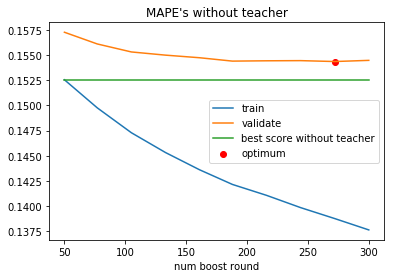

In [58]:
plt.title('MAPE\'s without teacher')
plt.plot(nboosts, pred_trains, label='train')
plt.plot(nboosts, pred_vals, label='validate')
i_optim = np.argmin(pred_vals)
plt.scatter(nboosts[i_optim], pred_vals[i_optim], label='optimum', c='r')

plt.plot(nboosts, best_score * np.ones(len(nboosts)), label='best score without teacher')

plt.xlabel('num boost round')
plt.legend()
best_try = pred_vals[i_optim]

### Начинаем делать сглаженные предсказания

In [0]:
def get_lightened_predictions(y_real, y_teacher, lambd):
  # lambd = 0 - учимся без "учителя"
  # lambd = 1 - учимся чисто на "учителе"
  return (1 - lambd) * y_real + lambd * y_teacher

def make_prediction_by_lambd(lambd):
  pred_vals = []
  for nboost in tqdm(nboosts):
    param_grid['num_boost_round'] = [nboost]
    to_train = get_lightened_predictions(y_train, teacher_prediction, lambd)
    model, params = get_best_model(X_train[subset], to_train,
                                   X_val[subset], y_val)
    pred_val = model.predict(X_val[subset].values)
    pred_vals.append(mape(y_val, pred_val))
  return pred_vals

In [109]:
nboosts_max = 600
nboosts = np.linspace(100, nboosts_max, (nboosts_max - 100) // 25).astype(int)

lambds = np.linspace(0, 1, 5)[1:]
lambds

array([0.25, 0.5 , 0.75, 1.  ])

In [103]:
to_plot = []
print("There will be {} tqdms".format(len(lambds)))
for lambd in lambds:
  to_plot.append(make_prediction_by_lambd(lambd))

  0%|          | 0/20 [00:00<?, ?it/s]

There will be 4 tqdms


100%|██████████| 20/20 [00:51<00:00,  4.05s/it]


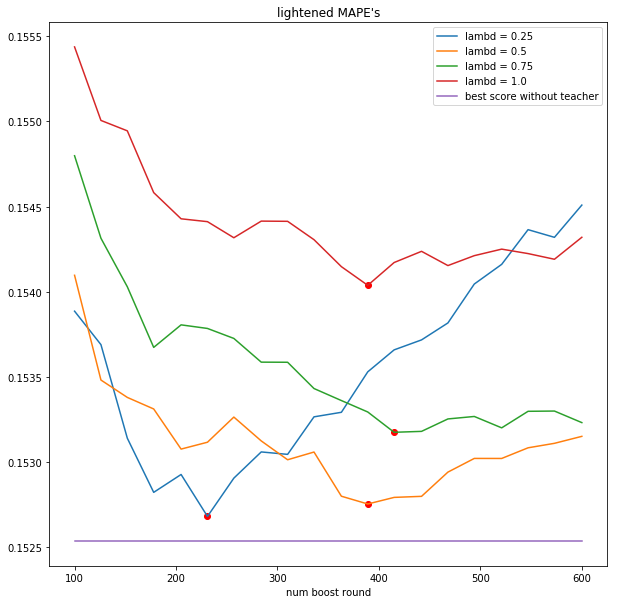

In [105]:
plt.figure(figsize=(10, 10))

plt.title('lightened MAPE\'s')

for pred_vals, lambd in zip(to_plot, lambds):
  i_optim = np.argmin(pred_vals)
  plt.plot(nboosts, pred_vals, label='lambd = {}'.format(lambd))
  plt.scatter(nboosts[i_optim], pred_vals[i_optim], c='r')
  
  
plt.plot(nboosts, best_score * np.ones(len(nboosts)), label='best score without teacher')

plt.xlabel('num boost round')
plt.legend()
best_try = pred_vals[i_optim]

### Плохо. Что же, опробуем примерно то же самое, но только возьмем меньшие lambd 

In [113]:
nboosts_max = 300
nboosts = np.linspace(100, nboosts_max, (nboosts_max - 100) // 25).astype(int)

lambds = np.linspace(0, 0.1, 5)
lambds

array([0.   , 0.025, 0.05 , 0.075, 0.1  ])

In [114]:
to_plot = []
print("There will be {} tqdms".format(len(lambds)))
for lambd in lambds:
  to_plot.append(make_prediction_by_lambd(lambd))

  0%|          | 0/8 [00:00<?, ?it/s]

There will be 5 tqdms


100%|██████████| 8/8 [00:11<00:00,  1.75s/it]


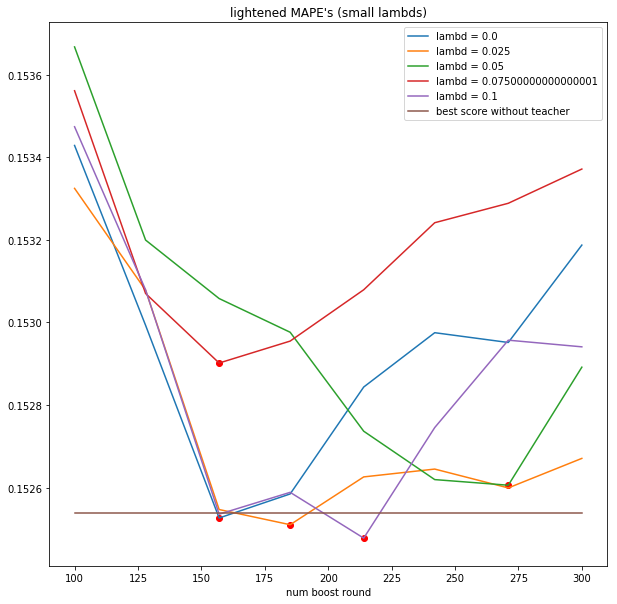

In [115]:
plt.figure(figsize=(10, 10))

plt.title('lightened MAPE\'s (small lambds)')

for pred_vals, lambd in zip(to_plot, lambds):
  i_optim = np.argmin(pred_vals)
  plt.plot(nboosts, pred_vals, label='lambd = {}'.format(lambd))
  plt.scatter(nboosts[i_optim], pred_vals[i_optim], c='r')
  
  
plt.plot(nboosts, best_score * np.ones(len(nboosts)), label='best score without teacher')

plt.xlabel('num boost round')
plt.legend()
best_try = pred_vals[i_optim]

In [0]:
mape()

### Все весьма плохо. Попробуем хотя бы применить смесь экспертов

Для этого требуется создать отдельный класс эстиматора со сглаживанием, и импортировать  некоторую вспомогательную штуку

In [141]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


import lasagne
import theano
import theano.tensor as T
import tqdm
import random

import keras
import tqdm

import numpy as np
from sklearn.externals import joblib

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

Using TensorFlow backend.


In [0]:
y_train_nn = y_train.values.reshape(-1, 1)
y_val_nn = y_val.values.reshape(-1, 1)
teacher_prediction_nn = teacher_prediction.reshape(-1, 1)

# Поменять loss!!

In [0]:
def estimator_loss(y, y_pred):
    return ((y - y_pred)**2).sum(-1)

class GatingEnsemble:
    
    def __init__(self, estimators, estimator_loss=estimator_loss, n_hidden_units=50,
                loging=False):

        self.estimators = estimators
        self.estimator_loss = estimator_loss
        self.n_hidden_units = n_hidden_units # number of hidden units in gate1
        
        self.regularizer=theano.shared(np.float32(0.5),name='entropy reg',allow_downcast=True)
        self.regularizer_decay=0.99
        self.loging=loging
    
    def log(self, string):
        if self.loging:
          print(string)
    
    def fit(self,X,y,n_iter=500):
        
        self.compile_gf((None,)+X.shape[1:])
        params_vec = []
        k = 0
        for i in range(n_iter):
            self.log("Launched iteration {} of {} ".format(i + 1, n_iter))
            self.refit_estimators(X,y)
            self.refit_gf(X,y,n_iter=10)
            self.regularizer.set_value(self.regularizer_decay*self.regularizer.get_value())
        
    
    def refit_gf(self,X,y,n_iter=7):
        best_estimator_ix = np.argmin([self.estimator_loss(y,est.predict(X))
                                 for est in self.estimators],axis=0).astype('int32')
        
        for i in range(n_iter):
            self.fit_nn_step(X,best_estimator_ix)
        
    def refit_estimators(self,X,y):
        #ix = np.random.randint(0,len(X),size=len(X))
        #X,y = X[ix],y[ix]
        W = self.get_W(X)
        W = (W == np.max(W,axis=1,keepdims=True)).astype('float32')
        W /= W.sum(axis=0,keepdims=True)
        W[np.isnan(W)] = 1./W.shape[1]
        
        # print(W[:1])
        self.estimators = [est.fit(X,y,sample_weight=W[:,i]) for i,est in enumerate(self.estimators)] # fails if estimator has no "sample_weight argument
        
        
        #
        # Вроде пока не нужно, но кто её знает
        # 
        
        # self.get_est_params = [est.get_params() for est in self.estimators]
        
    def build_gating_function(self,x_shape,n_gates):
        
        #Input layer (auxilary)
        input_layer = lasagne.layers.InputLayer(shape = x_shape)

        #fully connected layer, that takes input layer and applies <n_hidden_units> neurons to it.
        # nonlinearity here is sigmoid as in logistic regression
        dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=self.n_hidden_units, W=lasagne.init.Normal(0.01),
                                          nonlinearity = lasagne.nonlinearities.tanh,
                                          name = "hidden_dense_layer")
        
        

        #fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
        #We use softmax nonlinearity to make probabilities add up to 1
        dense_logit = lasagne.layers.DenseLayer(dense_1,num_units = n_gates,
                                                 nonlinearity = None,
                                                 name='output')
        
        dense_logit = lasagne.layers.GaussianNoiseLayer(dense_logit,0.01)
        
        dense_output = lasagne.layers.NonlinearityLayer(dense_logit,T.nnet.softmax)
        return dense_output
    
    def compile_gf(self,x_shape):
        
        input_X = T.matrix("X")
        
        target_W_of_x = T.ivector("W(x) target - probability that i-th estimator is best")
        
        nn = self.nn = self.build_gating_function(x_shape,n_gates=len(self.estimators))
        
        w_predicted = lasagne.layers.get_output(nn,inputs=input_X)
        
        loss = lasagne.objectives.categorical_crossentropy(w_predicted,target_W_of_x).mean()        
        loss += self.regularizer*(w_predicted*T.log(w_predicted)).sum(1).mean() #negative entropy
        
        
        nn_params = lasagne.layers.get_all_params(self.nn,trainable=True)
        
        updates = lasagne.updates.adamax(loss,nn_params)
        
        self.fit_nn_step = theano.function([input_X,target_W_of_x],loss, updates=updates)
        self.get_W = theano.function([input_X], w_predicted)
    
    def predict(self,X):
        W = self.get_W(X)        
        base_predictions = np.stack([est.predict(X) for est in self.estimators],axis=1)    
        return (W[:,:,None]*base_predictions).sum(axis=1)

Опробуем сначала на линеейных регрессорах, чтобы понять, что функция в целом работает

In [151]:
num_estimators = 4
estimators = [LinearRegression() for i in range(num_estimators)]

neural_ensemble = GatingEnsemble(estimators, 
                                    loging=True)

neural_ensemble.fit(X_train, y_train_nn, n_iter=10)

Launched iteration 1 of 10 
Launched iteration 2 of 10 
Launched iteration 3 of 10 
Launched iteration 4 of 10 
Launched iteration 5 of 10 
Launched iteration 6 of 10 
Launched iteration 7 of 10 
Launched iteration 8 of 10 
Launched iteration 9 of 10 
Launched iteration 10 of 10 


In [0]:
ens_val_predict_nn = neural_ensemble.predict(X_val)

In [153]:
mape(y_val, ens_val_predict_nn.ravel())

0.1963455987562903

Очень странная фигня: берем несколько одинаковых ансамблей, закидываем их  в смесь экспертов, получаем ухудшение качества... Оно, еще, кстати, сильно меняется с перезапусками процесса, что, в свою очередь, наоборот, неудивительно: внутри ведь нейронка. Теперь пишем собственный класс, содержащий в себе, на самом деле, lightgbm

In [0]:
class SimpleEstimator:
  def __init__(self, lambd, num_boost_round):
    self.lambd = lambd
    self.num_boost_round = num_boost_round

  def fit(self, X, Y, sample_weight = None):
    if sample_weight is None:
      sample_weight = np.array(np.ones(len(X)) / len(X))

    real_y = get_lightened_predictions(y_train_nn,
                                       teacher_prediction_nn, self.lambd)
    
    params = {
    'objective': 'regression',
    'metric': {'mape'},
    'num_leaves': 60,
    'verbose': 0
    }
    
    param_grid = {
       'learning_rate': [ 0.1],
       'n_estimators': [20],
       'num_boost_round': [self.num_boost_round],
       'boosting_type': ['gbdt'],
    }
    
    self.model = lgb.LGBMRegressor(params)
    self.model = GridSearchCV(self.model, param_grid, cv=3)
    self.model.fit(X, real_y.ravel(), sample_weight=sample_weight)
    self.model = self.model.best_estimator_
    return self
    
  def predict(self, X): 
    return self.model.predict(X).reshape(-1, 1)

In [0]:
simple_est = SimpleEstimator(lambd=0, num_boost_round = 150)
simple_est.fit(X_train, y_train_nn)
mape(y_val[:10], simple_est.predict(X_val))

In [0]:
params = [[0.1, 210], [0.25, 210], [0.75, 400]]
estimators = [SimpleEstimator(lambd, num_boost_round) for lambd,
              num_boost_round in params]

In [195]:
neural_ensemble = GatingEnsemble(estimators, 
                                    loging=True)

neural_ensemble.fit(X_train, y_train_nn, n_iter=10)

Launched iteration 1 of 10 
Launched iteration 2 of 10 
Launched iteration 3 of 10 
Launched iteration 4 of 10 
Launched iteration 5 of 10 
Launched iteration 6 of 10 
Launched iteration 7 of 10 
Launched iteration 8 of 10 
Launched iteration 9 of 10 
Launched iteration 10 of 10 


In [196]:
neural_ensemble.predict(X_val)[:10]

array([[309.94607078],
       [251.54508067],
       [177.3917084 ],
       [193.2316374 ],
       [137.77624949],
       [194.31314255],
       [220.90123285],
       [146.72304806],
       [171.64492317],
       [232.75028504]])

In [197]:
y_val_nn[:10]

array([[376.98412698],
       [274.03846154],
       [155.03937008],
       [209.26724138],
       [128.0155642 ],
       [190.26548673],
       [206.4516129 ],
       [148.10126582],
       [117.67676768],
       [246.53846154]])

In [198]:
mape(neural_ensemble.predict(X_val), y_val_nn)

0.15410770562712434

# Здесь мусор всякий

In [0]:
results = []
for lambd in lamds:
  to_train = get_lightened_predictions(y_train, teacher_prediction, lambd)
  

In [0]:
np.linspace(50, 500, 10).astype(int)

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])

In [0]:
#teacher_grid = np.linspace(300, 1000, 10).astype(int)
teacher_grid = []#np.linspace()
teacher_predictions = []

for teacher_n in tqdm(teacher_grid):
  param_grid = {
      'learning_rate': [ 0.1],
      'n_estimators': [20],
      'num_boost_round': [teacher_n],
      'boosting_type': ['gbdt'],
  }

  subset_full = X_train.columns

  model_all_features = get_best_model(X_train[subset_full], y_train, X_val[subset], y_val)
  pred_val = model_all_features.predict(X_val[subset_full].values)
  # print(mape(y_val, pred_val))
  pred_train = model_all_features.predict(X_train[subset_full].values)
  # print(mape(y_train, pred_train))

  teacher_prediction = pred_train
  teacher_predictions.append(teacher_prediction)

0it [00:00, ?it/s]


In [0]:
nboosts = np.linspace(150, 550, 10).astype(int)


def get_lightened_predictions(y_real, y_teacher, lambd):
  # lambd = 0 - учимся без "учителя"
  # lambd = 1 - учимся чисто на "учителе"
  return (1 - lambd) * y_real + lambd * y_teacher

def compare_qualities(lambd = 1):
  plt.figure(figsize=(12, 12))
  plt.title('MAPE\'s without teacher and lambd = {}'.format(lambd))
  for i in range(len(teacher_grid)):
    teacher_prediction = teacher_predictions[i]
    our_y = get_lightened_predictions(y_train, teacher_prediction, lambd)
    #pred_trains = []
    pred_vals_ = []

    for nboost in tqdm(nboosts):
      param_grid['num_boost_round'] = [nboost]
      model = get_best_model(X_train[subset], our_y, X_val[subset], y_val)                    #teacher_prediction, X_val[subset], y_val)

      #pred_train = model.predict(X_train[subset].values)
      pred_val = model.predict(X_val[subset].values)  

      #pred_trains.append(mape(y_train, pred_train))
      pred_vals_.append(mape(y_val, pred_val))


      #plt.plot(nboosts, pred_trains, label='train ')
    teacher_n = teacher_grid[i]
    plt.plot(nboosts, pred_vals_, label='validate for n = {} for teacher'.format(teacher_n))
    i_optim = np.argmin(pred_vals_)
    plt.scatter(nboosts[i_optim], pred_vals_[i_optim], c='r')

  #plt.axhline(best_score, xmin=np.min(nboosts), xmax=np.max(nboosts))#, linewidth=4, color='r')
  plt.plot(nboosts, best_score * np.ones(len(nboosts)), label='best score without teacher')
  plt.xlabel('num boost round')
  plt.legend()
  #plt.plot(nboosts, 0.5 * np.ones(len(nboosts)))
  
  
# compare_qualities()

100%|██████████| 10/10 [00:30<00:00,  3.98s/it]


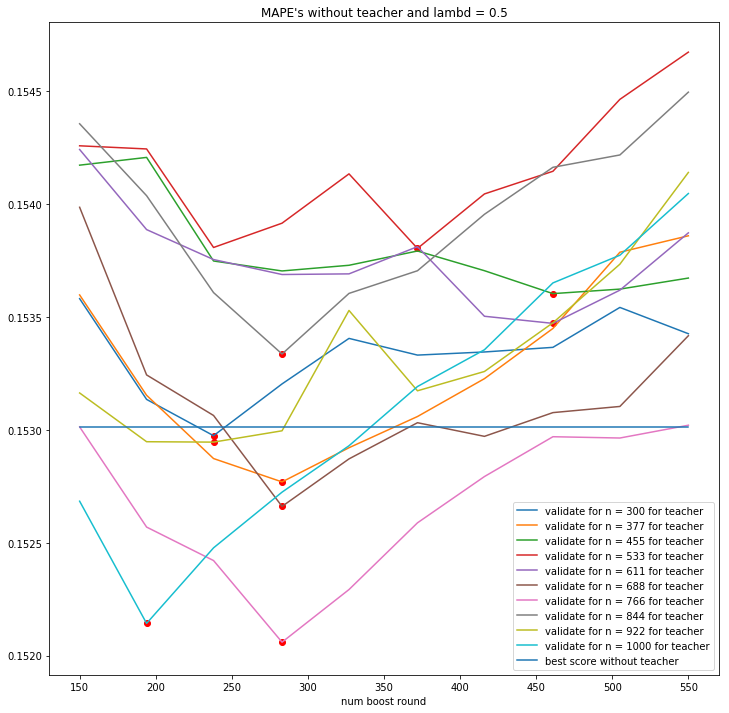

In [0]:
compare_qualities(0.5)

In [0]:
best_score

0.15301124910720773

In [0]:
get_lightened_predictions

<function __main__.get_lightened_predictions>

In [0]:
np.min(nboosts), np.max(nboosts)

(50, 300)

In [0]:
best_score

0.1530852249216249

In [0]:
#model = get_best_model(X_train[subset],
#                                    y_train, X_val[subset], y_val)
#pred_val = model.predict(X_val[subset].values)
#print(mape(y_val, pred_val))
#pred_train = model.predict(X_train[subset].values)
#mape(y_train, pred_train)

#imp_df = pd.DataFrame()
#imp_df["feature"] = subset
#imp_df["importance_gain"] = model.best_estimator_.feature_importances_#(importance_type='gain')
                                                              
#imp_df.sort_values('importance_gain', ascending=False)
